In [19]:
from distribution_fit_class import DistributionFit
from portfolio_optimization_class import PortfolioOptimization, optimize_windows
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [13]:
copulas = ["clayton_random", "gaussian", "t_student"]
# copulas = ["t_student"]
distributions = ["gauss_dist", "t_dist"]
window_size = 32
taus = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
maximum_weight = 0.3

In [ ]:
# number_of_samples = 10000

#if iter == 2 taus CUT else taus = [...]

for iter in range(2, 11):
    file_path = r'data\random_data\1_stocks_per_sector_' + f'{iter}_iter.csv'
    returns_df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    tau_aggregation = []
    for tau_index, tau in enumerate(taus):
        tau_dict = {}
        portfolios = optimize_windows(number_of_quarters=window_size, tau=tau, maximum_weight=maximum_weight, data_path=file_path)
        for copula in copulas:
            absolute_errors_norm = []
            absolute_errors_t = []
            absolute_percentage_errors_norm = []
            absolute_percentage_errors_t = []
            for window in range(0, 64):
                if window % 5 == 0:
                    print(f'Tau: {tau}, Cop: {copula} - {window}')
                distribution_fit = DistributionFit()
                distribution_fit.set_df(returns_df)
                distribution_fit.fit_distribution_all_stocks()

                simulated_data_path = r'../copulas_outputs/simulated_' + copula + '_11_stocks' + f'_{window}_window_{iter}_iter.csv'
                simulated_df = pd.read_csv(simulated_data_path)
                distribution_fit.set_simulated_data_from_df(simulated_df)
                distribution_fit.calculate_returns_from_simulated_quantiles()
                returns_norm = distribution_fit.get_simulated_return_norm()
                returns_t = distribution_fit.get_simulated_return_t_student()

                dist_list = [(returns_t, "t_dist"), (returns_norm, "gauss_dist")]
                for dist_returns, dist_name in dist_list:
                    optimizer = PortfolioOptimization()
                    optimizer.set_tau(tau)
                    optimizer.set_maximum_weight(0.3)
                    optimizer.load_simulated_data_from_df(dist_returns)

                    optimizer.build_model()
                    optimizer.solve(verbose=False)
                    evar = optimizer.get_solution_evar()
                    # print(evar)
                    # print(portfolios["EVAR"])
                    theoretical_evar = portfolios.iloc[window]["EVAR"]
                    absolute_error = abs((evar - theoretical_evar))
                    absolute_percentage_error = abs(absolute_error / theoretical_evar) * 100
                    if dist_name == "t_dist":
                        absolute_errors_t.append(absolute_error)
                        absolute_percentage_errors_t.append(absolute_percentage_error)
                    if dist_name == "gauss_dist":
                        absolute_errors_norm.append(absolute_error)
                        absolute_percentage_errors_norm.append(absolute_percentage_error)
            tau_dict[copula+"+t_dist_AE"] = absolute_errors_t
            tau_dict[copula+"+t_dist_APE"] = absolute_percentage_errors_t
            tau_dict[copula+"+gauss_dist_AE"] = absolute_errors_norm
            tau_dict[copula+"+gauss_dist_APE"] = absolute_percentage_errors_norm

        df = pd.DataFrame.from_dict(tau_dict)
        tau_str = str(tau).replace(".", "_")
        # output_path = r"../scores/taus/" + f'tau_{tau_str}/scores_{tau_str}{batch_num}.csv'
        output_path = r"data/errors/" + f'errors_tau_{tau_str}_iter_{iter}.csv'
        df.to_csv(output_path)







Tau: 0.0005, Cop: clayton_random - 0
Tau: 0.0005, Cop: clayton_random - 5
Tau: 0.0005, Cop: clayton_random - 10
Tau: 0.0005, Cop: clayton_random - 15
Tau: 0.0005, Cop: clayton_random - 20
Tau: 0.0005, Cop: clayton_random - 25
Tau: 0.0005, Cop: clayton_random - 30
Tau: 0.0005, Cop: clayton_random - 35
Tau: 0.0005, Cop: clayton_random - 40
Tau: 0.0005, Cop: clayton_random - 45
Tau: 0.0005, Cop: clayton_random - 50
Tau: 0.0005, Cop: clayton_random - 55
Tau: 0.0005, Cop: clayton_random - 60
Tau: 0.0005, Cop: gaussian - 0
Tau: 0.0005, Cop: gaussian - 5
Tau: 0.0005, Cop: gaussian - 10
Tau: 0.0005, Cop: gaussian - 15
Tau: 0.0005, Cop: gaussian - 20
Tau: 0.0005, Cop: gaussian - 25
Tau: 0.0005, Cop: gaussian - 30
Tau: 0.0005, Cop: gaussian - 35
Tau: 0.0005, Cop: gaussian - 40
Tau: 0.0005, Cop: gaussian - 45
Tau: 0.0005, Cop: gaussian - 50
Tau: 0.0005, Cop: gaussian - 55
Tau: 0.0005, Cop: gaussian - 60
Tau: 0.0005, Cop: t_student - 0
Tau: 0.0005, Cop: t_student - 5
Tau: 0.0005, Cop: t_student - 

KeyboardInterrupt: 

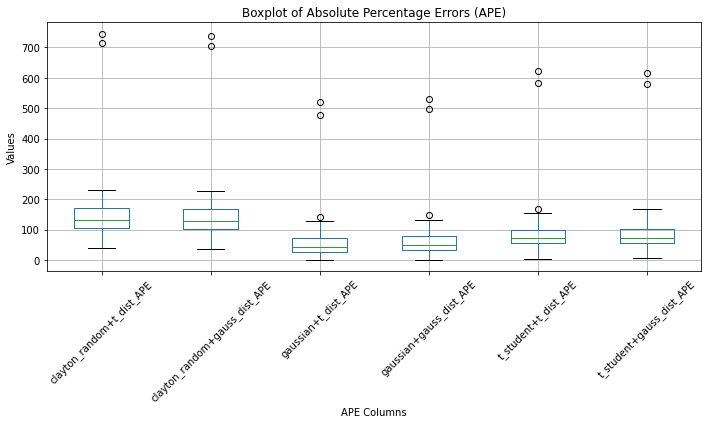

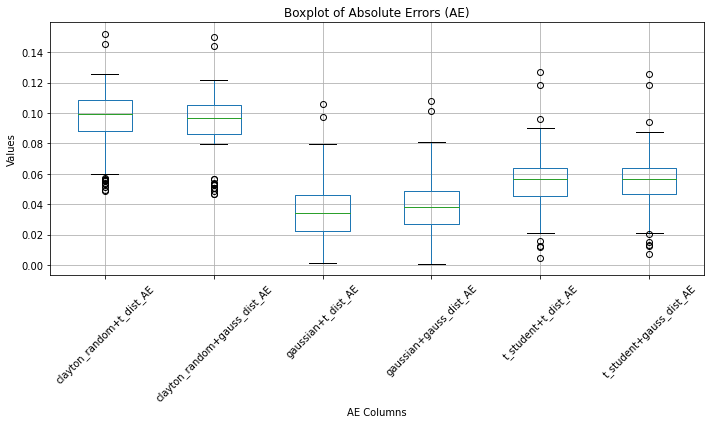

In [22]:
df = pd.read_csv("data/errors/errors_tau_0_001_iter_2.csv")
ape_columns = [col for col in df.columns if 'APE' in col]


plt.figure(figsize=(10, 6))
df[ape_columns].boxplot()
plt.title('Boxplot of Absolute Percentage Errors (APE)')
plt.xlabel('APE Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ae_columns = [col for col in df.columns if 'AE' in col]

plt.figure(figsize=(10, 6))
df[ae_columns].boxplot()
plt.title('Boxplot of Absolute Errors (AE)')
plt.xlabel('AE Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()